In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from collections import defaultdict
import sys
import imutils
from CheckBoxParser import *

# CheckBox Detection

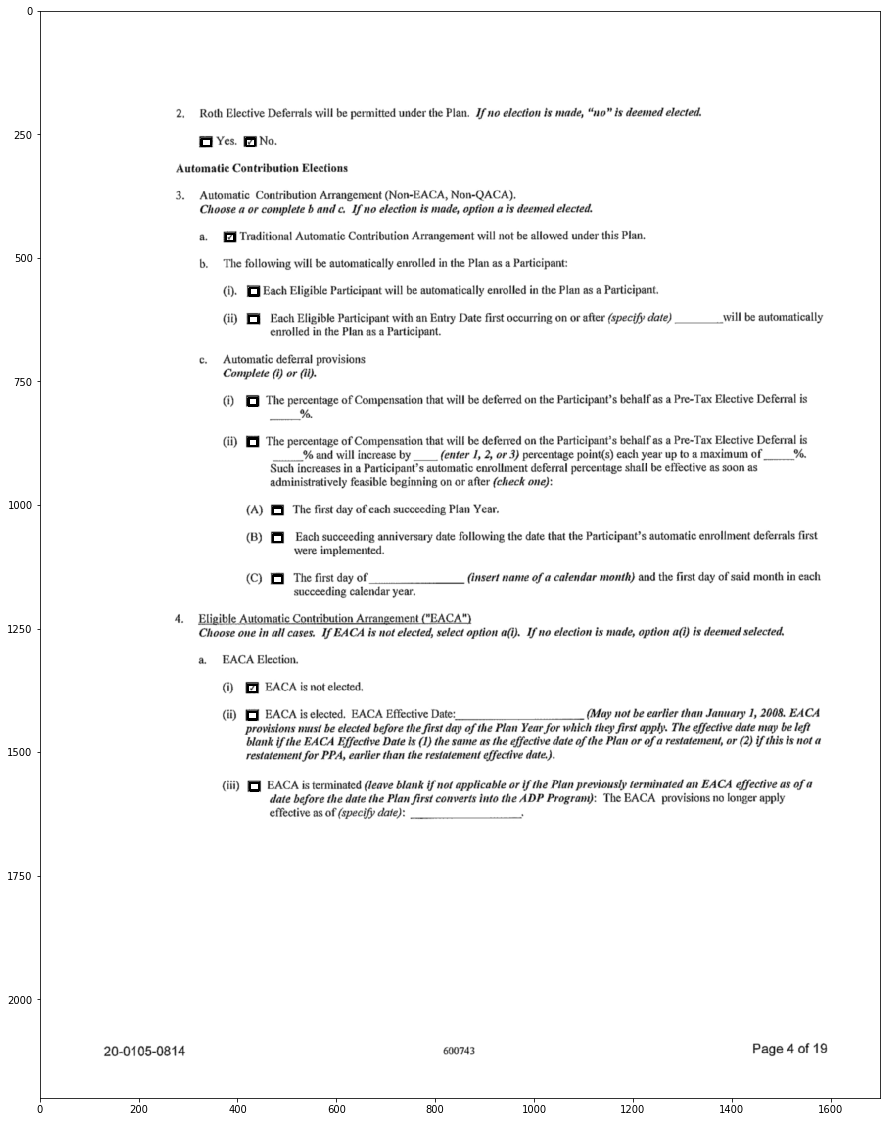

CheckBoxParser.py:126: RuntimeWarning: divide by zero encountered in divide
  q  = (c[:,2]-c[:,0]) / denom


{((321, 254, 29, 25), 'unchecked'): {((411, 254, 28, 25), 'checked'): {}},
 ((370, 447, 28, 25), 'checked'): {((415, 1359, 28, 25), 'checked'): {},
  ((415, 1414, 28, 25), 'unchecked'): {},
  ((416, 779, 28, 25), 'unchecked'): {},
  ((416, 861, 28, 25), 'unchecked'): {((466, 1000, 28, 24), 'unchecked'): {},
   ((466, 1055, 28, 25), 'unchecked'): {},
   ((466, 1138, 28, 25), 'unchecked'): {}},
  ((417, 613, 29, 24), 'unchecked'): {},
  ((418, 557, 28, 25), 'unchecked'): {},
  ((419, 1558, 28, 25), 'unchecked'): {}}}

In [4]:
def bplot(img):
    plt.figure(figsize=(30,20))
    plt.imshow(img,cmap="gray")
    plt.show()

def horizontal(img,scale=25):

    ## Generating Horizontal Mask

    horizontal = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 15,15)
    horizontalsize = scale
    horizontalStructure = cv2.getStructuringElement(cv2.MORPH_RECT ,(horizontalsize,1) )
    horizontal =  cv2.morphologyEx(horizontal, cv2.MORPH_CLOSE, horizontalStructure)
    horizontal = np.where(horizontal==0,1,0)
    return horizontal

def vertical(img):

    # Generate Vertical Mask

    vertical = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 15,15);
    verticalsize = vertical.shape[0] // 100
    verticalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, ( 1,verticalsize))
    vertical =  cv2.morphologyEx(vertical, cv2.MORPH_CLOSE, verticalStructure)
    vertical = np.where(vertical==0,1,0)
    return vertical


def generateCompleteMask(horizontal , vertical):
    mask = horizontal+vertical
    mask = np.where(mask>=1 ,255,mask)
    mask = mask.astype(np.uint8)
    return mask

class ShapeDetector:
    def detect(self, c):
        # initialize the shape name and approximate the contour
        shape = "unidentified"
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c,0.15*peri, True)
        # if the shape has 4 vertices, it is either a square or
        # a rectangle
        if len(approx) == 4:
            # compute the bounding box of the contour and use the
            # bounding box to compute the aspect ratio
            (x, y, w, h) = cv2.boundingRect(approx)
            ar = w / float(h)

            # a square will have an aspect ratio that is approximately
            # equal to one, otherwise, the shape is a rectangle
            shape = "square" if ar >= 0.95 and ar <= 1.05 else "rectangle"
        # return the name of the shape
        return shape
    

def execute(path ,plot=True):
    img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
    img = cv2.GaussianBlur(img, (5, 5), 1)
    mask = generateCompleteMask(horizontal(img) , vertical(img))

    # find contours in the thresholded image and initialize the
    # shape detector
    i=0
    l=[]
    ratio = 1
    cnts = cv2.findContours(mask, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    sd = ShapeDetector()
    # loop over the contours
    for c in cnts:
        # compute the center of the contour, then detect the name of the
        # shape using only the contour
        shape = sd.detect(c)
        if shape=="square" or shape=="rectangle":
            # multiply the contour (x, y)-coordinates by the resize ratio,
            # then draw the contours and the name of the shape on the image
            c = c.astype("float")
            c *= ratio
            c = c.astype("int")
            x,y,w,h = cv2.boundingRect(c)
            l.append((x,y,w,h))
            cv2.waitKey(0)
            i+=1

    imgg =img.copy()
    ss =[]
    for c,i in enumerate(l):
        x,y,w,h = i
        cv2.rectangle(imgg,(x+5,y+5),(x+w-5,y+h-5),(0),3)

        s = img[y+5:y+h-5,x+5:x+w-5]
        _,s = cv2.threshold(s, 127,255, cv2.THRESH_BINARY_INV)
        flag="unchecked"
        if s.mean()>10:
            flag="checked"
        ss.append( [ [x,y,w,h], flag] )
    if plot: bplot(imgg)
    return ss

d = execute("/home/amidezcod/Downloads/ADP10_22710/ADP10_22710-04.jpg",plot=True)
all_checked_boxes = run(d)
all_checked_boxes

# Line Detection

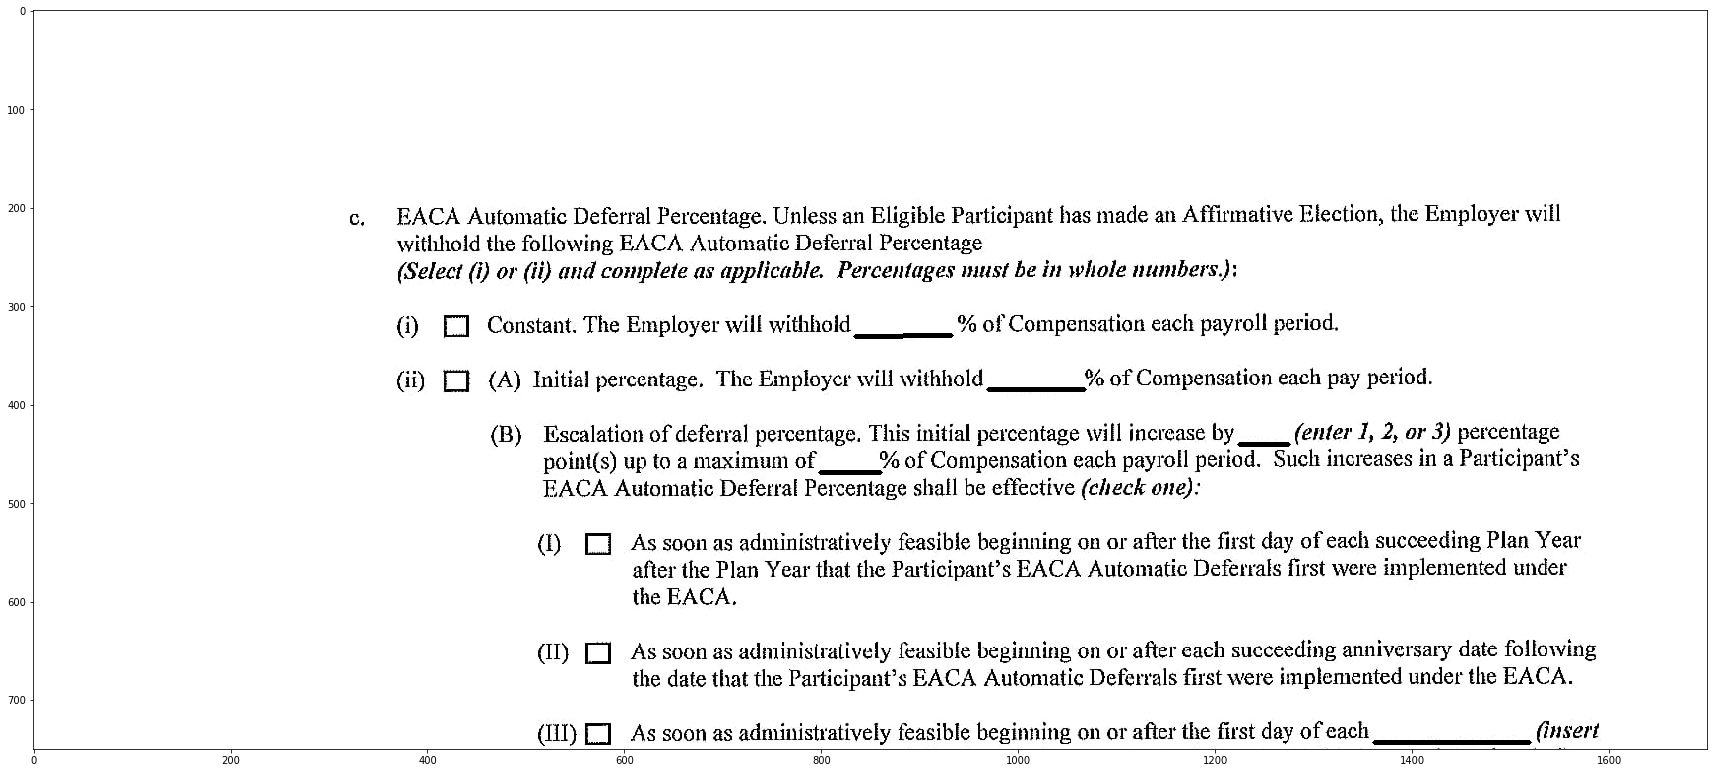

[[799, 469, 860, 469],
 [835, 331, 932, 330],
 [970, 385, 1067, 385],
 [1225, 440, 1275, 440],
 [1362, 743, 1519, 743]]

In [40]:
def remove_redundant_line(lines):
    lines = sorted(lines, key  = lambda x:(x[2],x[1]))
    lines = np.array(lines)
    i=0
    d= defaultdict(list)
    l = []
    while i<len(lines):
        first_x1,first_y1,first_x2,first_y2 = lines[i]
        j=i+1
        k=0
        d[i].append([first_x1,first_y1,first_x2,first_y2])
        while j < len(lines):
            second_x1,second_y1,second_x2,second_y2 = lines[j]
            j+=1
            if  abs(second_y1-first_y1) <= 4:
                k+=1
                d[i].append([second_x1,second_y1,second_x2,second_y2]) 
            else:
                break
        d[i] = sorted(d[i] , key = lambda x: (x[2]-x[0] , x[0]) ,reverse=True)
        if len(d[i]) ==1 or len(d[i]) == 2:
            l.append(d[i][0])
            del d[i]
        else:
            pass
        i=i+k+1

    for values in d.values():
        i=0
        while i< len(values):
            first_value = values[i]
            j=i+1
            while j< len(values):
                second_value = values[j]
                j+=1
                if first_value[2] >= second_value[2] and first_value[0] <=  second_value[0]:
                    if first_value not in l:
                        l.append(first_value)
                    values.remove(second_value)
                else:
                    continue
            i+=1
    del d
    return l

def get_horizontal_line_coords(full_image, area):
    """
    params:
    image: full image
    area: area in which we have to look for the coordinates of horizontal line

    return:
    list_of_coords: list having bbox of the coordinates of horizonal lines [(), ()..]
    """
    xmin,ymin,xmax,ymax = area
    list_of_coords=None
    rho = 1
    theta = np.pi/180
    threshold = 30
    min_line_length = 50
    max_line_gap = 1

    sub_img = full_image[ymin:ymax , xmin:xmax]
    horizontal_mask = horizontal(sub_img,scale=35)
    horizontal_mask = np.where(horizontal_mask>=1 ,255,horizontal_mask)
    horizontal_mask = horizontal_mask.astype(np.uint8)

    lines = cv2.HoughLinesP(horizontal_mask, rho, theta, threshold,min_line_length, max_line_gap)
    
    if lines is not None and len(lines) !=0:
        lines = lines.reshape(-1,4)
        lines = remove_redundant_line(lines)
    else:
        lines = np.array([])
        
    #### comment from here####
    for x1,y1,x2,y2 in lines:
        cv2.line(sub_img,(x1,y1),(x2,y2),(0,0,0),3)
    bplot(sub_img)
    #### till here ### just for visual purpose
    
    return lines

img = cv2.imread("/home/amidezcod/Downloads/ADP10_22710/ADP10_22710-06.jpg",cv2.IMREAD_GRAYSCALE)
# Getting a subsection for the image for testing purpose
lines = get_horizontal_line_coords(img[0:750].copy(),(0,0,10000,10000))
lines

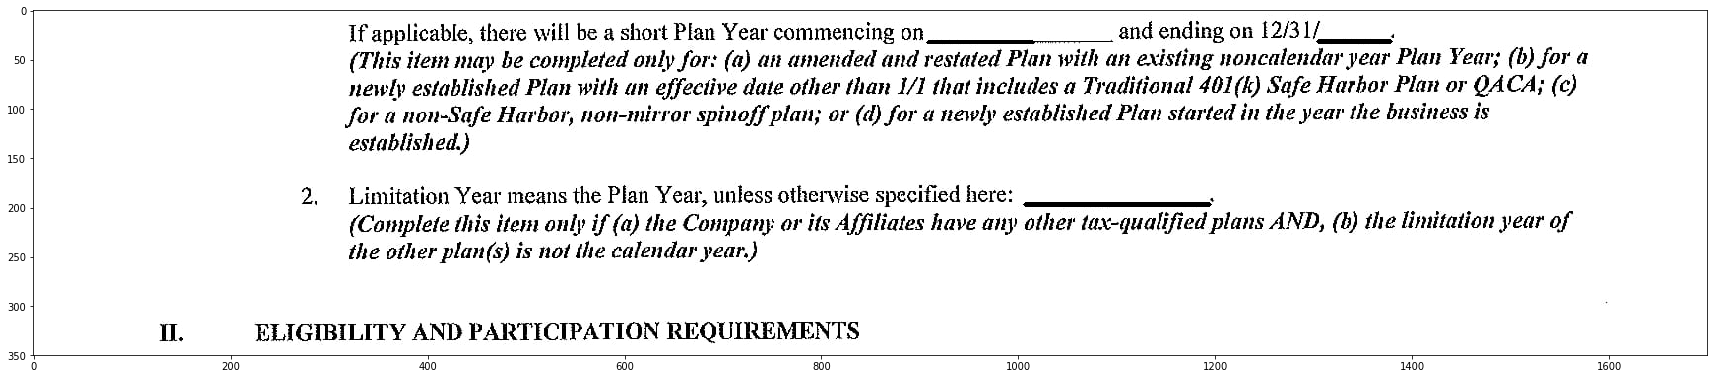

[[1007, 197, 1194, 197], [1305, 31, 1378, 31], [909, 32, 1015, 32]]

In [42]:
img = cv2.imread("/home/amidezcod/Downloads/ADP10_22710/ADP10_22710-02.jpg",cv2.IMREAD_GRAYSCALE)
# Getting a subsection for the image for testing purpose
lines = get_horizontal_line_coords(img[300:650].copy(),(0,0,10000,10000))
lines